# Computational Neuroscience Crash Course (2019)
** Arthur Leblois & Nicolas P. Rougier**, Institute of Neurodegenerative Diseases, Bordeaux, France.  
Course material and program at https://github.com/rougier/NeuroComp-Bordeaux-2019

**Warning**

> Prior to this course, you need to install [Anaconda](https://www.anaconda.com/distribution/) that is the easiest way to install the scientific Python stack on Linux, Windows, and Mac OS X. After installation, make sure you can start a Jupyter notebook from the Anaconda navigator because we'll use it extensively during this course.

### 1. Configuration of the notebook

We need first to setup a few options in the notebook such as to have inline plots as well as a nicer output on OSX.  
There is not much to understand here, these options are documented in the [Jupyer notebook documentation](https://jupyter-notebook.readthedocs.io/en/stable/notebook.html)

In [4]:
# Ask jupyter to display plots inline
%matplotlib inline

# OSX specific (for a nicer display on "retina" screen)
%config InlineBackend.figure_format = 'retina'

**Note**: In order to run the code in a specific code cell, you'll have to type `shift`+`return` on the selected cell. If you do that manually, you'll have to run each cell from top to bottom (order is important). If you want to run all the cell, you can also click the run button at the top of the notebook. To edit a cell (code or text), double-click in it.

  
  
### 2. Loading libraries
Next step is to load all the Python libraries that will be needed for processing & displaying our data. Namely:
* [NumPy](https://www.numpy.org/) which is the fundamental package for scientific computing with Python.
* [Matplotlib](https://matplotlib.org/) which is a plotting library that produces publication quality figures. 
* [SciPy](https://www.scipy.org/) which is a Python-based ecosystem of open-source software for mathematics, science, and engineering.
* [IPython](https://ipython.org/) that provides a rich architecture for interactive computing

Note that during this course, we'll only use a small part of IPython (to play sound).

In [5]:
# Numerical package
import numpy as np

# Package to display figures
import matplotlib.pyplot as plt

# Package to read wav files
from scipy.io import wavfile

# Package to display widgets inside the notebook
from IPython.display import Audio, display

  
### 3. Loading data

The first thing to do is to load our data from a local file that must be present in your `data` directory. To do that, we'll write a `get_local_data` function that reads a `wav` filename (`wav` file are sound files encoded in the [Waveform audio file format](https://fr.wikipedia.org/wiki/Waveform_Audio_File_Format)) using a dedicated function of scipy.

In [6]:
def get_data(filename = None):
    rate, signal = wavfile.read(filename)
    return rate, signal

We can now load some data and check for their properties.

In [7]:
filename = "../data/2_April_24_2018_34577797.wav"
rate, signal = get_data("../data/2_April_24_2018_34577797.wav")

print("Frequency: {:.1f}kHz".format(rate/1000))
print("Length: {}".format(len(signal)))

Frequency: 44.1kHz
Length: 436224


#### Exercise
The file has been read and we know that the frequency is 44.1 kHz and the number of data points is 436224.  
Try to compute the duration of the signal.

In [8]:
# Solution to the exercise
duration = len(signal)/rate
print("Frequency: {:.1f}kHz".format(rate/1000))
print("Duration: {:.2f} second(s)".format(duration))

Frequency: 44.1kHz
Duration: 9.89 second(s)



### 4. Visualizing our data

We can now display our data using the `plot` function from matplotlib. To do that, we need to have the X and Y coordinates of points. The Y data is given by the `signal` but we need to generate the corresponding X data. Knowing the duration and the number of Y data, we can write X using the numpy [linspace(start,stop,num)](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) function as:

In [9]:
Y = signal
X = np.linspace(0, duration, len(Y))

We're now ready to create a new figure and plot our data

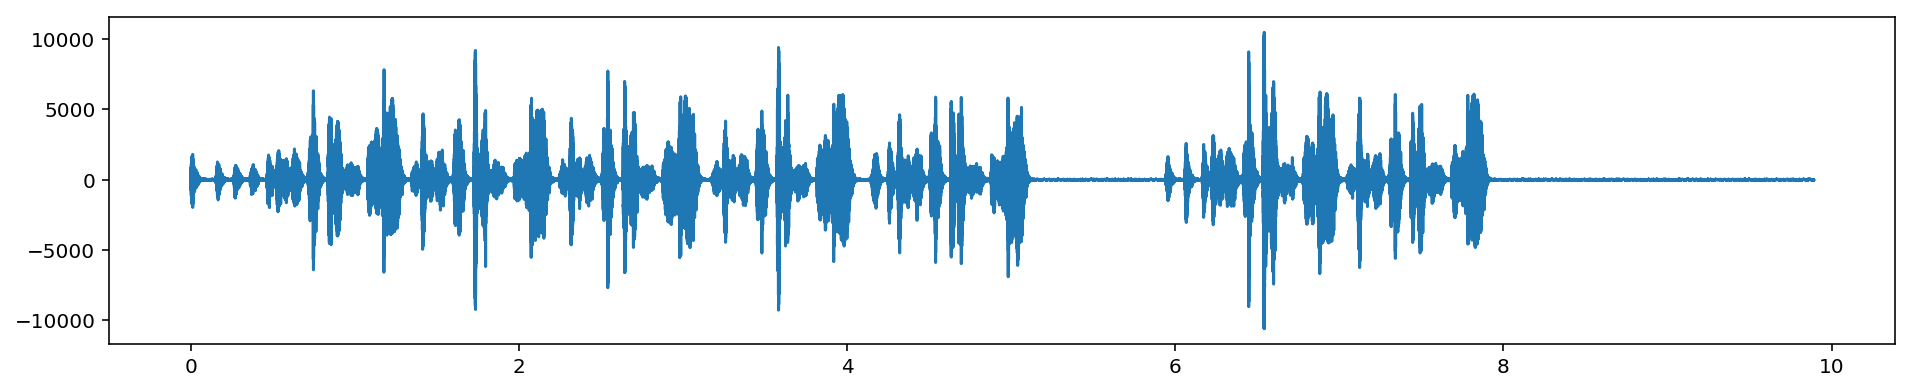

In [10]:
plt.figure(figsize=(16,3))
plt.plot(X, Y);

If you want to see only a subpart of the signal, you can limit explicitely the x range using the [xlim(xmin,xmax)](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.xlim.html) function as shown below where we modified the y range as well using the [ylim(ymin,ymax)](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.ylim.html)

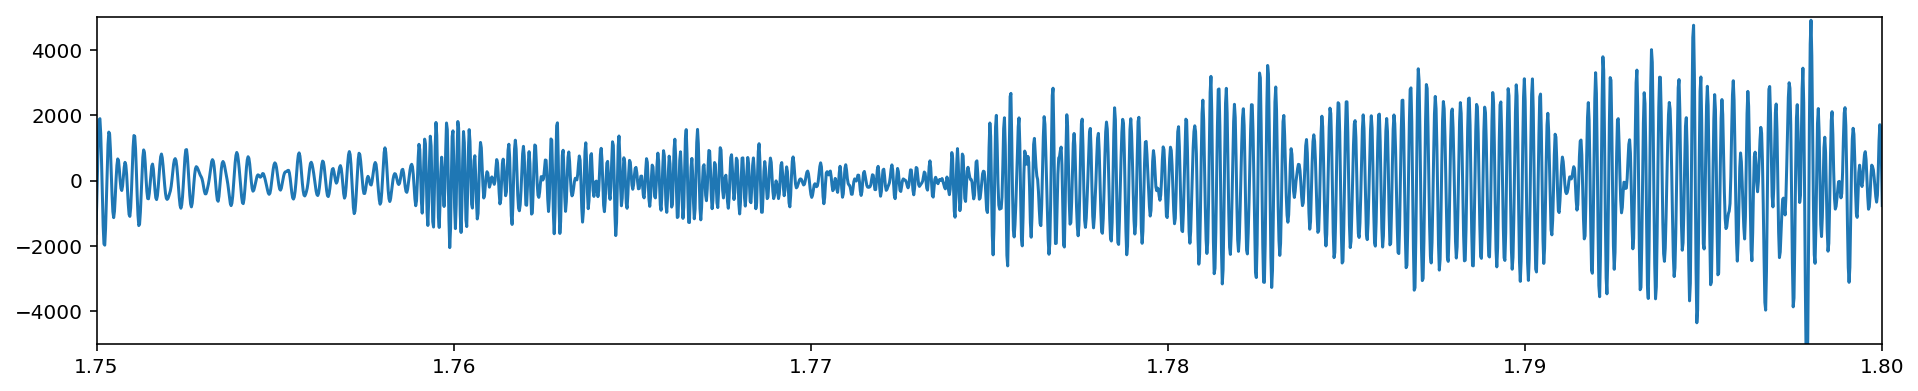

In [11]:
plt.figure(figsize=(16,3))
plt.plot(X, Y);
plt.xlim(1.75,1.80);
plt.ylim(-5000,5000);

Furthermore, and knowing our data is an audio file, we can benefit from a better visualization using the [specgram](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.specgram.html) function of matplotlib that is dedicated to the visualization of spectrogram.

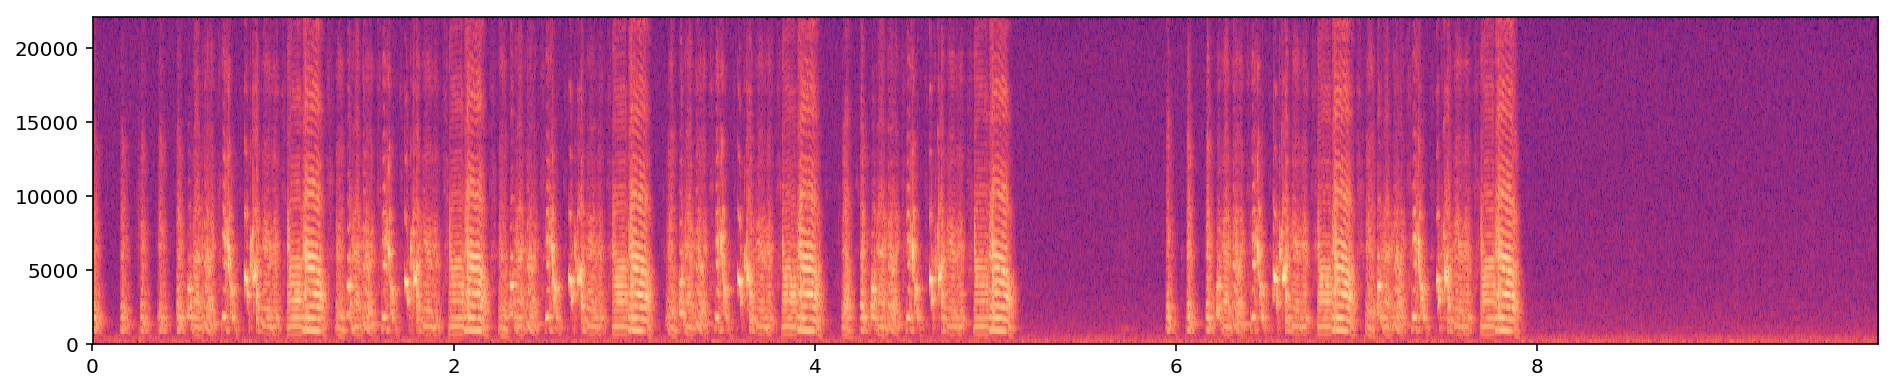

In [12]:
plt.figure(figsize=(16,3))
plt.specgram(signal, Fs=rate, cmap="magma");

And last, but not least, using the IPython library, we can display a widget in order to play the file.

In [13]:
# Display a widget to play the sound
display(Audio(filename))


### 5. Smoothing the signal

We want to smooth the signal by averaging each value with neighboring values, using a Gaussian window. To do that, we first need to define the neighboring range (in seconds). Then we define a gaussian signal over this range and centered in the middle and finally we compute the smooth signal (enveloppe).

In [14]:
# Duration of the time window over which to smooth the signal
dt = 0.025
trange = int(dt*rate)
# Standard deviation of the gaussian
sigma = trange/4
# Actual temporal window over which to compute the Gaussian
window = np.arange(-trange//2,trange//2)
# Gaussian function over window and standard deviation sigma
gaussian = np.exp(-(window/sigma)**2)

Let us visualize our smoothing window.

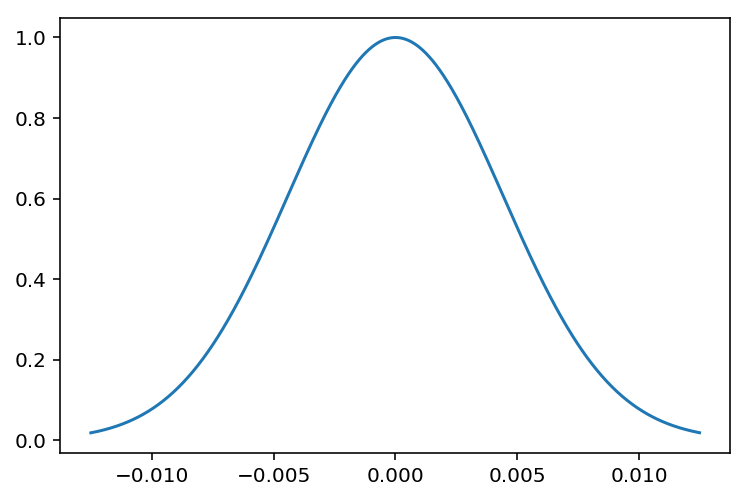

In [15]:
# Plot the Gaussian 
plt.plot(window/rate, gaussian);

Now, let us compte the envelope using the  convolution product that is mathematically defined as:
$(f * g)(t) \triangleq\ \int_{-\infty}^\infty f(t-\tau) g(\tau)\, d\tau$

The illustration below (from the [Wikipedia page on convolution](https://en.wikipedia.org/wiki/Convolution)) shows how it is computed:

![](https://upload.wikimedia.org/wikipedia/commons/6/6a/Convolution_of_box_signal_with_itself2.gif)


In [16]:
# Smooth the signal using the numpy convolution function
envelope = np.convolve(abs(signal), gaussian, mode='same') / gaussian.sum()

If we did things properly, the signal and it enveloppe variations should be aligned.  
Let's check:

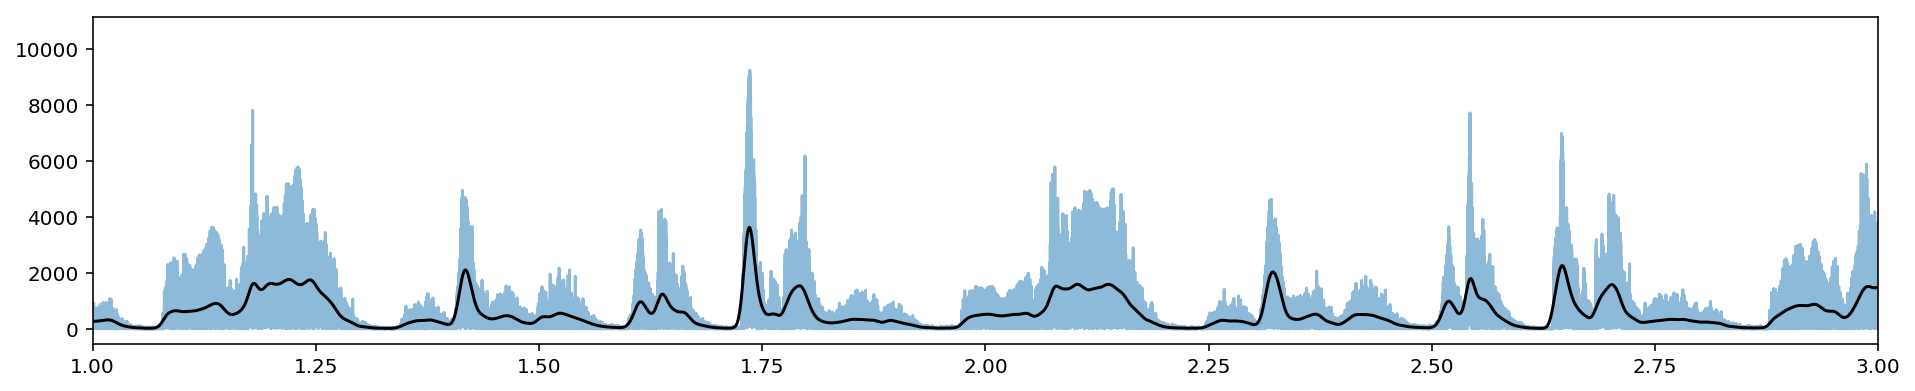

In [17]:
# Display the raw signal and the spectrogram
X = np.linspace(0, duration, len(Y))
plt.figure(figsize=(16,3))
plt.plot(X, abs(signal), alpha=0.5)
plt.plot(X, envelope, color="black")
plt.xlim(1,3);

### 6. Auto-correlation

We can now compute the auto-corellation of the signal, that is, the correlation of the signal by itself. Howewer, since the signal is quite large, we'll first extract only a few points linearly spread over the signal and then compute the auto-correlation.

In [18]:
R = envelope[::100]
C = np.correlate(R, R, mode='same') / (R**2).sum()

An we can now visualize the result in the frequency domain.

In [1]:
F = np.linspace(0, len(signal)/rate, len(C))
plt.plot(F, C);

NameError: name 'np' is not defined

We can visually see there is a peak around 25kHZ. Let's try to locate this peak frequency more accurately.

In [20]:
# Search for the index of the maximal value in C
i = np.argmax(C)
# Find the corresponding frequency
f = F[i]
print("Peak at {:.2f} kHz".format(f/1000))

Peak at 22.05 kHz


### 7. Wrap-up

It's now time to write a function that will find the peak frequency automatically. To do this, we just need to wrap-up what we've written so far and choose the relevant arguments to give when we call the function.

In [21]:
def get_peak(data, dt=0.025):
    """
    Retrieve the peak frequency of an audio signal using a Gaussian
    smoothing window (with duration dt)
    
    data: (rate, signal)
        data is an audio signal made of 2 variables. First one (rate)
        is the frequency of the signal and second one (signal) is the
        actual signal.
    
    dt: float
        Duration of the time window (Gaussian) to smooth the signal. 
        Default value is 250 milliseconds.
    """
    
    rate, signal = data
    window = np.arange(-dt*rate//2,dt*rate//2)
    gaussian = np.exp(-(4*window/(dt*rate))**2)
    R = (np.convolve(abs(signal), gaussian, mode='same') / gaussian.sum())[::100]
    C = np.correlate(R, R, mode='same') / (R**2).sum()
    F = np.linspace(0, rate, len(C))
    return F[np.argmax(C)]

Ok, let's use it.

In [22]:
filename = "../data/2_April_24_2018_34577797.wav"
data = get_data(filename)
peak = get_peak(data)
print("Peak at {:.2f} kHz".format(f/1000))

Peak at 22.05 kHz


You may have noticed that we added a string at the beginnind of the function definition. It is called a docstring and it represents the documentation of your function. When you want to read this documentation, you can type:

In [23]:
help(get_peak)

Help on function get_peak in module __main__:

get_peak(data, dt=0.025)
    Retrieve the peak frequency of an audio signal using a Gaussian
    smoothing window (with duration dt)
    
    data: (rate, signal)
        data is an audio signal made of 2 variables. First one (rate)
        is the frequency of the signal and second one (signal) is the
        actual signal.
    
    dt: float
        Duration of the time window (Gaussian) to smooth the signal. 
        Default value is 250 milliseconds.



### 8. Batch processing

So far, we've working with a unique file whose name was known to us. We would like now to process all the wav files in the data directory. This means we need to first find them and then process them. To do that, we'll use the [glob](https://docs.python.org/3/library/glob.html) library:

In [24]:
import glob

for filename in glob.glob("../data/*.wav"):
    print(filename)

../data/2_April_24_2018_34747559.wav
../data/2_April_24_2018_34577797.wav
../data/2_April_24_2018_34622000.wav


Let's process them. For a nice display of the filename, we'll use the [os.path](https://docs.python.org/3/library/os.path.html) library that allows to work with filenames.

In [25]:
import os

for filename in glob.glob("../data/*.wav"):
    basename = os.path.basename(filename)
    data = get_data(filename)
    peak = get_peak(data)
    print('"{0}" has a peak at {1:.2f} kHz'.format(basename, f/1000))
    display(Audio(filename))

"2_April_24_2018_34747559.wav" has a peak at 22.05 kHz


"2_April_24_2018_34577797.wav" has a peak at 22.05 kHz


"2_April_24_2018_34622000.wav" has a peak at 22.05 kHz


If you look closer at the filename, you might realize they follow a specific naming scheme. Let us try to decode it.

In [28]:
for filename in glob.glob("../data/*.wav"):
    basename = os.path.basename(filename)
    filename = basename.split('.')[0]            # Get rid of the extension
    box, month, day, year, time = filename.split("_") # Split filename into 5 strings
    print("{0} : {1} {2} {3}".format(basename, day, month, year))

2_April_24_2018_34747559.wav : 24 April 2018
2_April_24_2018_34577797.wav : 24 April 2018
2_April_24_2018_34622000.wav : 24 April 2018
